In [491]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
#from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Modelos
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB


In [492]:
dataset = pd.read_csv('assets/train.csv')

In [493]:
datatest = pd.read_csv('assets/test.csv')

In [494]:
datatest.shape[0]

4277

In [495]:
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Análise Exploratória

In [496]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Podemos perceber que o datas set possui 7 features categóricas e 6 numéricas e vários dados faltantes em quase todas as features, pois temos 8693 dados não nulos na coluna "Transported".

In [497]:
print('DADOS FALTANTES DO TREINO:')
print(dataset.isna().sum())
print('')
print('DADOS FALTANTES DO TESTE:')
print(datatest.isna().sum())

DADOS FALTANTES DO TREINO:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

DADOS FALTANTES DO TESTE:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Primeiramente vamos fazer a análise exploratória dos dados, isto porque teremos uma noção melhor dos dados como um todo antes de lidar com estes dados faltantes.

## Análise dos dados numéricos.

Text(0.5, 0, 'Idade em anos')

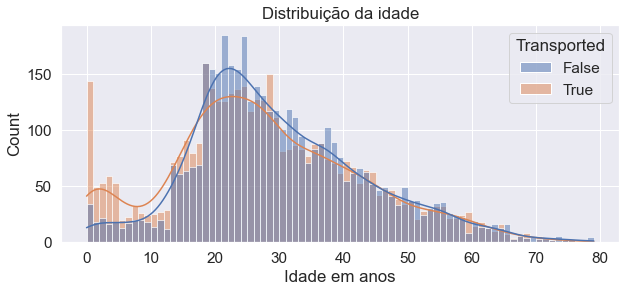

In [498]:
plt.figure(figsize=(10,4))
sns.histplot(data=dataset, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Distribuição da idade')
plt.xlabel('Idade em anos')

Podemos perceber que pessoas mais jovens tiveram mais chances de serem tranpostadas do que as mais velhas. 
Pessoas entre 20 e 30 anos tiveram menos chances de serem tranpostadas. 

Criaremos uma nova coluna separando as idades por grupos. 

In [499]:
dataset['Age'].fillna(200, inplace=True)
datatest['Age'].fillna(200, inplace=True)

dataset['Age_group']=np.nan
dataset.loc[dataset['Age']<=12,'Age_group']= 0
dataset.loc[(dataset['Age']>12) & (dataset['Age']<18),'Age_group']=1
dataset.loc[(dataset['Age']>=18) & (dataset['Age']<=25),'Age_group']=2
dataset.loc[(dataset['Age']>25) & (dataset['Age']<=30),'Age_group']=3
dataset.loc[(dataset['Age']>30) & (dataset['Age']<=50),'Age_group']=4
dataset.loc[(dataset['Age']>50) & (dataset['Age']<=199),'Age_group']=5
dataset.loc[dataset['Age']>199,'Age_group']=6

datatest['Age_group']=np.nan
datatest.loc[datatest['Age']<=12,'Age_group']=0
datatest.loc[(datatest['Age']>12) & (datatest['Age']<18),'Age_group']=1
datatest.loc[(datatest['Age']>=18) & (datatest['Age']<=25),'Age_group']=2
datatest.loc[(datatest['Age']>25) & (datatest['Age']<=30),'Age_group']=3
datatest.loc[(datatest['Age']>30) & (datatest['Age']<=50),'Age_group']=4
datatest.loc[(datatest['Age']>50) & (datatest['Age']<=199),'Age_group']=5
datatest.loc[datatest['Age']>199,'Age_group']=6

Text(0.5, 0, 'Grupo das idades')

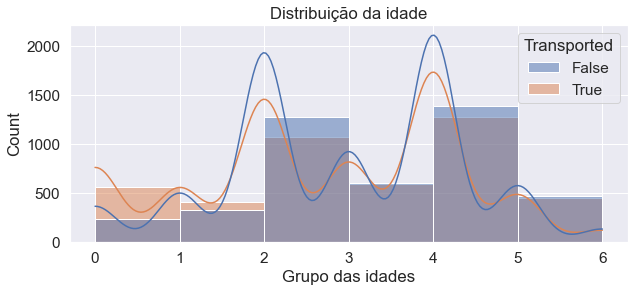

In [500]:
plt.figure(figsize=(10,4))

sns.histplot(data=dataset, x='Age_group', hue='Transported', binwidth=1, kde=True)
plt.title('Distribuição da idade')
plt.xlabel('Grupo das idades')

Explorando as Features de gastos.

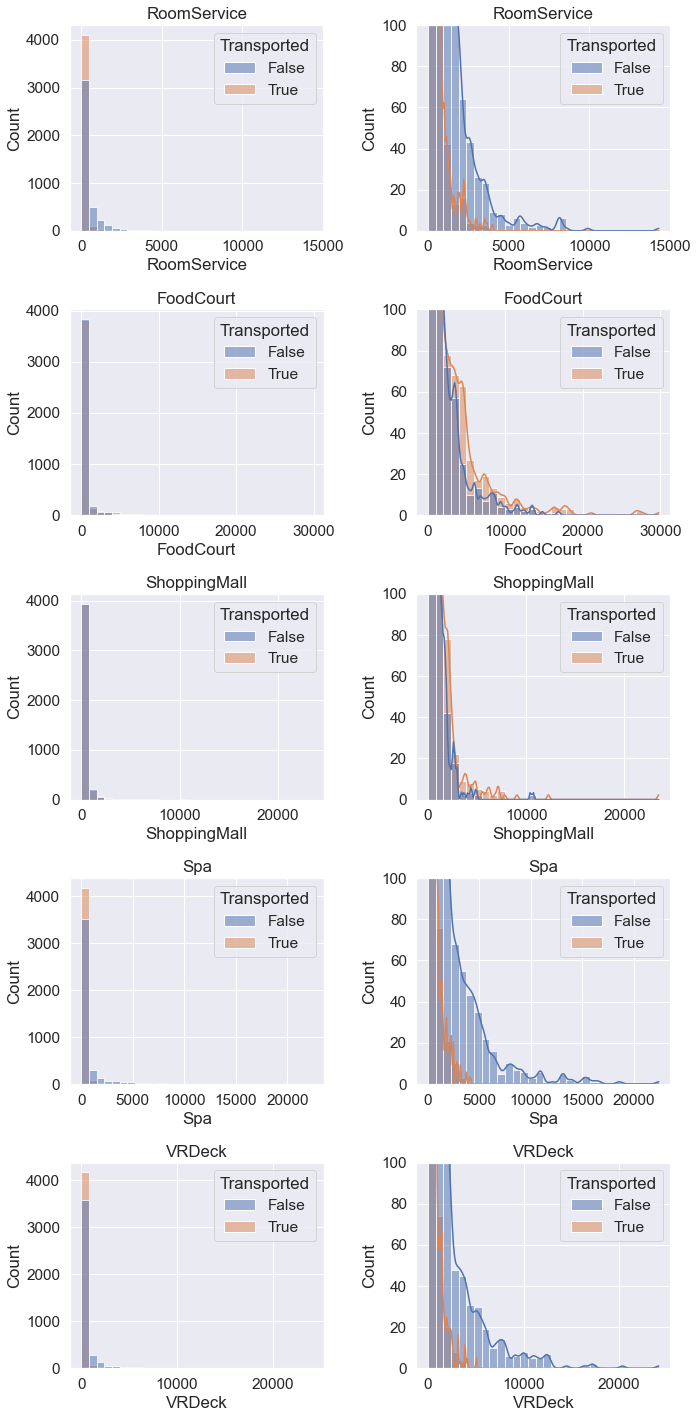

In [501]:
# Features de gastos
gastos_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(gastos_feats):
    # Plot normal
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=dataset, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Plot truncado
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=dataset, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

Podemos perceber algumas coisas:
- A maioria das pessoas não gastaram dinheiro. 
- As distribuições de RomService, Spa e VRDeck são diferentes das outras, pois nestes casos percebe-se que as pessoas que gastaram menos tiveram uma tendência maior de serem transpostadas.

Criarei duas novas features, uma com o total gasto por cada pessoa e uma binária se a pessoa gastou ou não.

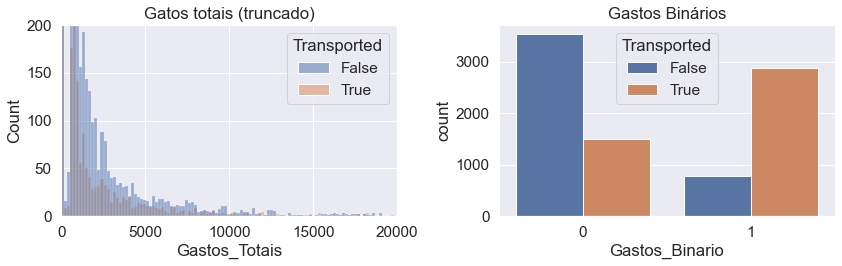

In [502]:
dataset['Gastos_Totais']=dataset[gastos_feats].sum(axis=1)
dataset['Gastos_Binario']=(dataset['Gastos_Totais']==0).astype(int)

# New features - test set
datatest['Gastos_Totais']=datatest[gastos_feats].sum(axis=1)
datatest['Gastos_Binario']=(datatest['Gastos_Totais']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=dataset, x='Gastos_Totais', hue='Transported', bins=200)
plt.title('Gatos totais (truncado)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=dataset, x='Gastos_Binario', hue='Transported')
plt.title('Gastos Binários')
fig.tight_layout()

## Análise dos dados Categóricos  

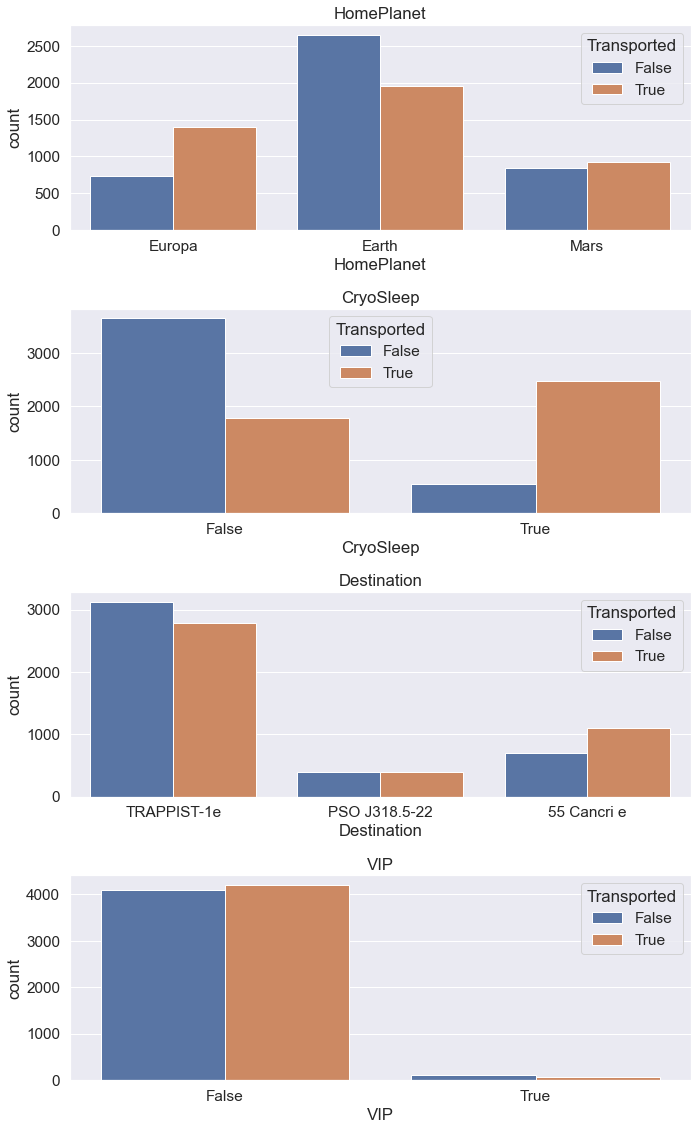

In [503]:
# Features Categoricas
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=dataset, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

Em relaçao ao planeta de origem podemos ver que:
- Quem vem do planeta Europa tem mais chances de ser tranportado.
- Quem vem do planeta Terra tem menos chances de ser transportado.
- Quem vem de Marte tem chances equilibradas.

Em relação ao estado de Cryosleep:
- Quem estava em CryoSleep tiveram mais chances de serem transportados. 

Isto mostra que esssa feature deve ser muito importante no modelo.

Em relação ao destino da viagem as variavéis parecem ser equilibradas. 

Na feature VIP podemos perceber que a grande maioria é de false. Não irei usar essa features para não gerar overfiting.

In [504]:
dataset.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group,Gastos_Totais,Gastos_Binario
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,4.0,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5.0,10383.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,4.0,5176.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1.0,1091.0,0
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,4.0,774.0,0
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,3.0,1584.0,0
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,3.0,0.0,1
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,4.0,1018.0,0
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,1.0,0.0,1


Olhando para o dataset, podemos perceber que o PassegenderID é composto por um número que é o grupo do passageiro e o segundo número a indentificação do passageiro. 
Levando isto em consideração vamos separar estes números para melhor agrupamento dos dados.

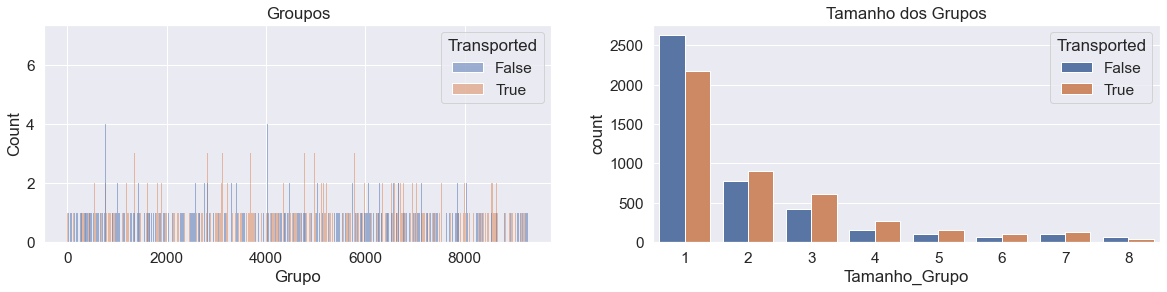

In [505]:

dataset['Grupo'] = dataset['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
datatest['Grupo'] = datatest['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)


dataset['Tamanho_Grupo']=dataset['Grupo'].map(lambda x: pd.concat([dataset['Grupo'], datatest['Grupo']]).value_counts()[x])
datatest['Tamanho_Grupo']=datatest['Grupo'].map(lambda x: pd.concat([dataset['Grupo'], datatest['Grupo']]).value_counts()[x])


plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=dataset, x='Grupo', hue='Transported', binwidth=1)
plt.title('Groupos')

plt.subplot(1,2,2)
sns.countplot(data=dataset, x='Tamanho_Grupo', hue='Transported')
plt.title('Tamanho dos Grupos')
fig.tight_layout()

Trabalhar com a feature grupo não parece ser uma boa ideia, pois sua cardinalidade é bem grande (maior que 6000) e demorou um pouco pra rodar o seu gráfico, já com a Tamanho_Grupo parece ser interessante, até mesmo por separar quem estava viajando sozinho.

O número da cabine de cada passageiro é composto por três itens, o deck, o número e o lado. Irei separar estes três dados. 

In [506]:
#Deixando os dados faltantes como outliers, no final eu volto para análise futura
dataset['Cabin'].fillna('Z/9999/Z', inplace=True)
datatest['Cabin'].fillna('Z/9999/Z', inplace=True)


dataset['Deck_Cabine'] = dataset['Cabin'].apply(lambda x: x.split('/')[0])
dataset['Numero_Cabine'] = dataset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
dataset['Lado_Cabine'] = dataset['Cabin'].apply(lambda x: x.split('/')[2])


datatest['Deck_Cabine'] = datatest['Cabin'].apply(lambda x: x.split('/')[0])
datatest['Numero_Cabine'] = datatest['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
datatest['Lado_Cabine'] = datatest['Cabin'].apply(lambda x: x.split('/')[2])

#Voltando com os dados faltantes
dataset.loc[dataset['Deck_Cabine']=='Z', 'Deck_Cabine']=np.nan
dataset.loc[dataset['Numero_Cabine']==9999, 'Numero_Cabine']=np.nan
dataset.loc[dataset['Lado_Cabine']=='Z', 'Lado_Cabine']=np.nan
datatest.loc[datatest['Deck_Cabine']=='Z', 'Deck_Cabine']=np.nan
datatest.loc[datatest['Numero_Cabine']==9999, 'Numero_Cabine']=np.nan
datatest.loc[datatest['Lado_Cabine']=='Z', 'Lado_Cabine']=np.nan

#Retirando a Feature Cabine, pois não preciso dela mais
dataset.drop('Cabin', axis=1, inplace=True)
datatest.drop('Cabin', axis=1, inplace=True)

Agora iremos fazer uma análise visual destes dados separados.


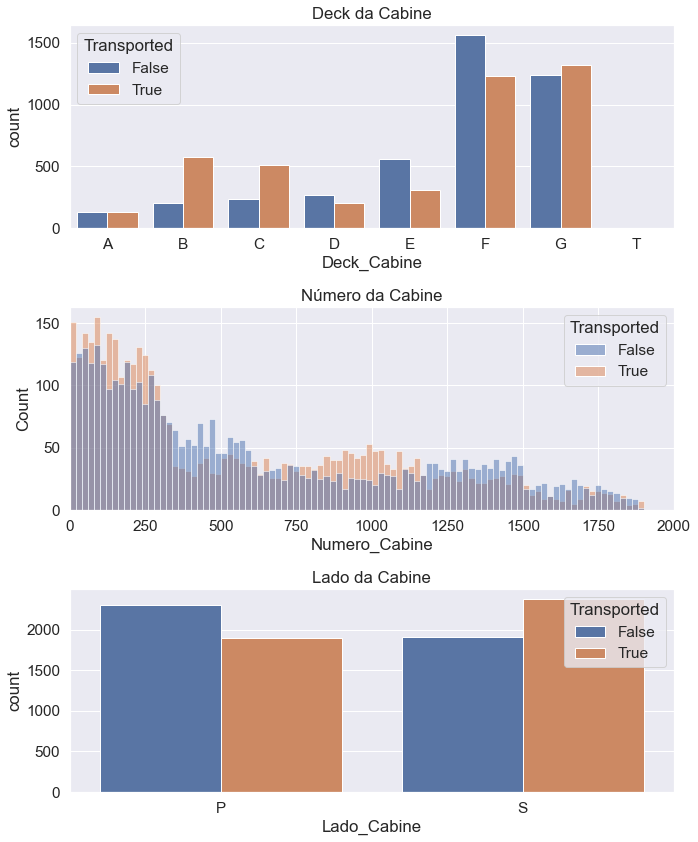

In [507]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=dataset, x='Deck_Cabine', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Deck da Cabine')

plt.subplot(3,1,2)
sns.histplot(data=dataset, x='Numero_Cabine', hue='Transported',binwidth=20)
plt.title('Número da Cabine')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=dataset, x='Lado_Cabine', hue='Transported')
plt.title('Lado da Cabine')
fig.tight_layout()


Aqui podemos perceber duas coisas:
- O Deck T parece ser um outlier(poucos casos)
- O Número da Cabine parece ter um padrão de em média cada 300 números, então vou agrupá-los.

In [508]:

dataset['Regiao_cabine_1']=(dataset['Numero_Cabine']<300).astype(int)   # one-hot encoding
dataset['Regiao_cabine_2']=((dataset['Numero_Cabine']>=300) & (dataset['Numero_Cabine']<600)).astype(int)
dataset['Regiao_cabine_3']=((dataset['Numero_Cabine']>=600) & (dataset['Numero_Cabine']<900)).astype(int)
dataset['Regiao_cabine_4']=((dataset['Numero_Cabine']>=900) & (dataset['Numero_Cabine']<1200)).astype(int)
dataset['Regiao_cabine_5']=((dataset['Numero_Cabine']>=1200) & (dataset['Numero_Cabine']<1500)).astype(int)
dataset['Regiao_cabine_6']=((dataset['Numero_Cabine']>=1500) & (dataset['Numero_Cabine']<1800)).astype(int)
dataset['Regiao_cabine_7']=(dataset['Numero_Cabine']>=1800).astype(int)


datatest['Regiao_cabine_1']=(datatest['Numero_Cabine']<300).astype(int)   # one-hot encoding
datatest['Regiao_cabine_2']=((datatest['Numero_Cabine']>=300) & (datatest['Numero_Cabine']<600)).astype(int)
datatest['Regiao_cabine_3']=((datatest['Numero_Cabine']>=600) & (datatest['Numero_Cabine']<900)).astype(int)
datatest['Regiao_cabine_4']=((datatest['Numero_Cabine']>=900) & (datatest['Numero_Cabine']<1200)).astype(int)
datatest['Regiao_cabine_5']=((datatest['Numero_Cabine']>=1200) & (datatest['Numero_Cabine']<1500)).astype(int)
datatest['Regiao_cabine_6']=((datatest['Numero_Cabine']>=1500) & (datatest['Numero_Cabine']<1800)).astype(int)
datatest['Regiao_cabine_7']=(datatest['Numero_Cabine']>=1800).astype(int)

Aqui separamos com o padrão do one-hot encoding, pensando que este é um bom método para manter a independência das Features região da cabine.

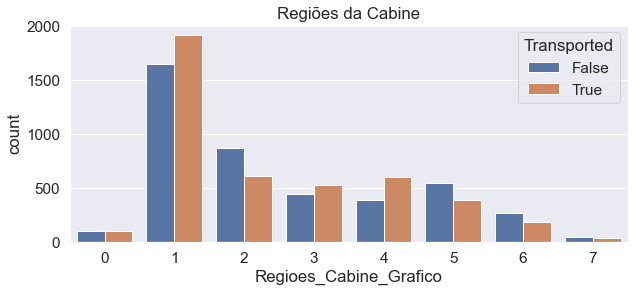

In [509]:
plt.figure(figsize=(10,4))
dataset['Regioes_Cabine_Grafico']=(dataset['Regiao_cabine_1']+2*dataset['Regiao_cabine_2']+3*dataset['Regiao_cabine_3']+4*dataset['Regiao_cabine_4']+5*dataset['Regiao_cabine_5']+6*dataset['Regiao_cabine_6']+7*dataset['Regiao_cabine_7']).astype(int)
sns.countplot(data=dataset, x='Regioes_Cabine_Grafico', hue='Transported')
plt.title('Regiões da Cabine')
dataset.drop('Regioes_Cabine_Grafico', axis=1, inplace=True)

Separando as famílias por sobrenome

In [510]:

dataset['Name'].fillna('Unknown Unknown', inplace=True)
datatest['Name'].fillna('Unknown Unknown', inplace=True)


dataset['Sobrenome']=dataset['Name'].str.split().str[-1]
datatest['Sobrenome']=datatest['Name'].str.split().str[-1]


dataset['Tamanho_Familia']=dataset['Sobrenome'].map(lambda x: pd.concat([dataset['Sobrenome'],datatest['Sobrenome']]).value_counts()[x])
datatest['Tamanho_Familia']=datatest['Sobrenome'].map(lambda x: pd.concat([dataset['Sobrenome'],datatest['Sobrenome']]).value_counts()[x])


dataset.loc[dataset['Sobrenome']=='Unknown','Sobrenome']=np.nan
dataset.loc[dataset['Tamanho_Familia']>100,'Tamanho_Familia']=np.nan
datatest.loc[datatest['Sobrenome']=='Unknown','Sobrenome']=np.nan
datatest.loc[datatest['Tamanho_Familia']>100,'Tamanho_Familia']=np.nan


dataset.drop('Name', axis=1, inplace=True)
datatest.drop('Name', axis=1, inplace=True)

## Lidando com os dados faltantes 

In [511]:
datatest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      4277 non-null   object 
 1   HomePlanet       4190 non-null   object 
 2   CryoSleep        4184 non-null   object 
 3   Destination      4185 non-null   object 
 4   Age              4277 non-null   float64
 5   VIP              4184 non-null   object 
 6   RoomService      4195 non-null   float64
 7   FoodCourt        4171 non-null   float64
 8   ShoppingMall     4179 non-null   float64
 9   Spa              4176 non-null   float64
 10  VRDeck           4197 non-null   float64
 11  Age_group        4277 non-null   float64
 12  Gastos_Totais    4277 non-null   float64
 13  Gastos_Binario   4277 non-null   int32  
 14  Grupo            4277 non-null   int32  
 15  Tamanho_Grupo    4277 non-null   int64  
 16  Deck_Cabine      4177 non-null   object 
 17  Numero_Cabine 

Podemos ver que o dataset de teste também tem dados faltantes. Para facilitar vamos juntar os dados de treino e os dados de teste, sem a coluna dos transportados, para tratá-los ao mesmo tempo. 

In [512]:
data_transportados=dataset['Transported'].copy().astype(int)
dataset_sem_transportados=dataset.drop('Transported', axis=1).copy()

# Concatenate dataframes
datafaltantes=pd.concat([dataset_sem_transportados, datatest], axis=0).reset_index(drop=True)

Vamos preencher os dados faltantes da Feature HomePlanet

In [513]:
# HomePlanet por Grupo(hpg)
hpg=datafaltantes.groupby(['Grupo','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
hpg.head()

HomePlanet,Earth,Europa,Mars
Grupo,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Número de planetas únicos por grupo')

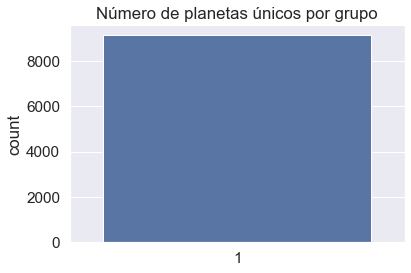

In [514]:
sns.countplot((hpg>0).sum(axis=1))
plt.title('Número de planetas únicos por grupo')

Podemos perceber que todos no mesmo grupo pertencem ao mesmo planeta de origem, então vamos preencher estes dados. 

In [515]:
hp_antes=datafaltantes['HomePlanet'].isna().sum()


hpg_index=datafaltantes[datafaltantes['HomePlanet'].isna()][(datafaltantes[datafaltantes['HomePlanet'].isna()]['Grupo']).isin(hpg.index)].index


datafaltantes.loc[hpg_index,'HomePlanet']=datafaltantes.iloc[hpg_index,:]['Grupo'].map(lambda x: hpg.idxmax(axis=1)[x])


print('Número de dados faltantes em HomePlanet antes:',hp_antes)
print('Número de dados faltantes em HomePlanet depois:',datafaltantes['HomePlanet'].isna().sum())

Número de dados faltantes em HomePlanet antes: 288
Número de dados faltantes em HomePlanet depois: 157


In [516]:
# HomePlanet por Deck
hpdk=datafaltantes.groupby(['Deck_Cabine','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

<AxesSubplot:xlabel='Deck_Cabine', ylabel='HomePlanet'>

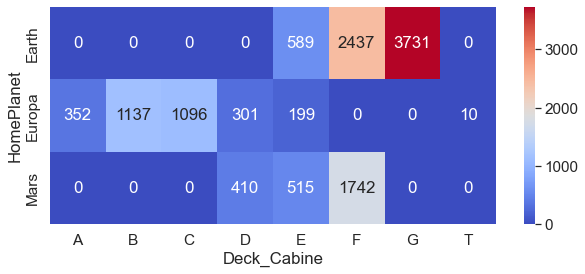

In [517]:
plt.figure(figsize=(10,4))
sns.heatmap(hpdk.T, annot=True, fmt='g', cmap='coolwarm')

Podemos perceber que:
- Passageiros dos grupos A, B, C e T vem do planeta Europa. 
- Passageiros do grupo G vem do planeta Terra. 
- Passageiros dos grupos D, E e F podem vim de planetas diferentes. 

Sendo assim, podemos preencher os dados dos grupos A, B, C, G e T.

In [518]:

hp_antes=datafaltantes['HomePlanet'].isna().sum()


datafaltantes.loc[(datafaltantes['HomePlanet'].isna()) & (datafaltantes['Deck_Cabine'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'


datafaltantes.loc[(datafaltantes['HomePlanet'].isna()) & (datafaltantes['Deck_Cabine']=='G'), 'HomePlanet']='Earth'


print('Número de dados faltantes em HomePlanet antes:',hp_antes)
print('Número de dados faltantes em HomePlanet depois:',datafaltantes['HomePlanet'].isna().sum())


Número de dados faltantes em HomePlanet antes: 157
Número de dados faltantes em HomePlanet depois: 94


Hipótese: Pessoas da mesma família devem vir de um mesmo planeta.


Então vou separar os passageiros pelo sobrenome.

Text(0.5, 1.0, 'Número de planetas por sobrenome')

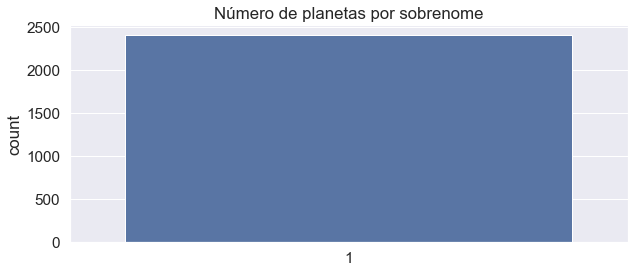

In [519]:
# HomePlanet por sobrenome(hpsm)
hpsm=datafaltantes.groupby(['Sobrenome','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)


plt.figure(figsize=(10,4))
sns.countplot((hpsm>0).sum(axis=1))
plt.title('Número de planetas por sobrenome')

In [520]:
hp_antes=datafaltantes['HomePlanet'].isna().sum()


hpsm_index=datafaltantes[datafaltantes['HomePlanet'].isna()][(datafaltantes[datafaltantes['HomePlanet'].isna()]['Sobrenome']).isin(hpsm.index)].index


datafaltantes.loc[hpsm_index,'HomePlanet']=datafaltantes.iloc[hpsm_index,:]['Sobrenome'].map(lambda x: hpsm.idxmax(axis=1)[x])


print('Número de dados faltantes em HomePlanet antes:',hp_antes)
print('Número de dados faltantes em HomePlanet depois:',datafaltantes['HomePlanet'].isna().sum())

Número de dados faltantes em HomePlanet antes: 94
Número de dados faltantes em HomePlanet depois: 10


Apenas 10 dados faltantes agora, vamos visualizar estes dados.

In [521]:
datafaltantes[datafaltantes['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


Todas as pessoas tem o mesmo destino, vamos dar uma olhada se encontramos um padrão neste destino.

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

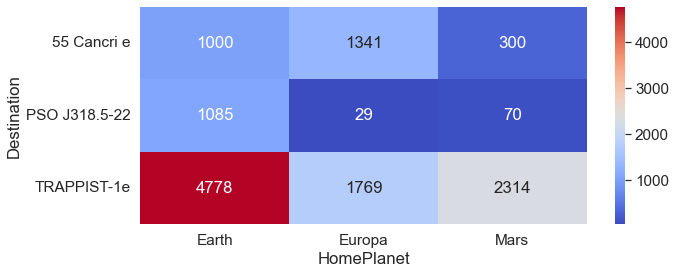

In [522]:
# HomePlanet por destino(hpd)
hpd=datafaltantes.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)


plt.figure(figsize=(10,4))
sns.heatmap(hpd.T, annot=True, fmt='g', cmap='coolwarm')

Podemos perceber que a grande maioria das pessoas que vão para o planeta 'TRAPPIST-1e' tem como origem o planeta Terra. Então, vamos preencher estes dados como essa origem, entretanto precisamos tomar cuidado com as pessoas do deck D, pois essas nunca partem da terra. Para estes casos colocaremos como origem Marte, pois é o segundo planeta com mais pessoas neste destino.

In [523]:
hp_antes=datafaltantes['HomePlanet'].isna().sum()


datafaltantes.loc[(datafaltantes['HomePlanet'].isna()) & ~(datafaltantes['Deck_Cabine']=='D'), 'HomePlanet']='Earth'
datafaltantes.loc[(datafaltantes['HomePlanet'].isna()) & (datafaltantes['Deck_Cabine']=='D'), 'HomePlanet']='Mars'

print('Número de dados faltantes em HomePlanet antes:',hp_antes)
print('Número de dados faltantes em HomePlanet depois:',datafaltantes['HomePlanet'].isna().sum())

Número de dados faltantes em HomePlanet antes: 10
Número de dados faltantes em HomePlanet depois: 0


Tratando dos dados faltantes da Feature Destino.

Como a grande maioria das pessoas estão indo para 'TRAPPIST-1e', vamos preencher os dados falantes com essa origem.

In [524]:

d_antes=datafaltantes['Destination'].isna().sum()


datafaltantes.loc[(datafaltantes['Destination'].isna()), 'Destination']='TRAPPIST-1e'


print('Número de dados faltantes em Destination antes:',d_antes)
print('Número de dados faltantes em Destination depois:',datafaltantes['Destination'].isna().sum())

Número de dados faltantes em Destination antes: 274
Número de dados faltantes em Destination depois: 0


Tratando dos dados faltantes das Features Sobrenome e grupo.

Text(0.5, 1.0, 'Número de sobrenomes únicos por grupo')

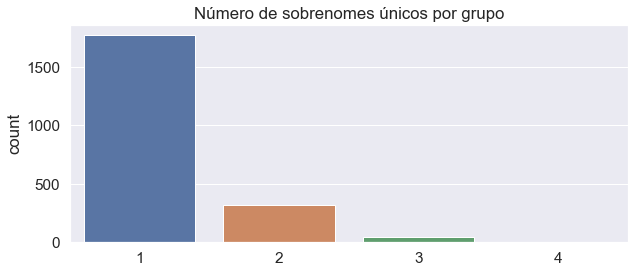

In [525]:
# Sobrenomes por grupo (sbgp)
sbgp =datafaltantes[datafaltantes['Tamanho_Grupo']>1].groupby(['Grupo','Sobrenome'])['Sobrenome'].size().unstack().fillna(0)


plt.figure(figsize=(10,4))
sns.countplot((sbgp>0).sum(axis=1))
plt.title('Número de sobrenomes únicos por grupo')

Podemos perceber aqui, que a grande maioria dos grupos são com sobrenomes únicos. Isto indica que os grupos são normalmente formados por pessoas da mesma família. 

Sendo assim, irei preencher sobrenomes faltantes de um grupo pelo sobrenome com maior frequência dentro do mesmo grupo.


In [526]:
sb_antes=datafaltantes['Sobrenome'].isna().sum()


sb_index=datafaltantes[datafaltantes['Sobrenome'].isna()][(datafaltantes[datafaltantes['Sobrenome'].isna()]['Grupo']).isin(sbgp.index)].index


datafaltantes.loc[sb_index,'Sobrenome']=datafaltantes.iloc[sb_index,:]['Grupo'].map(lambda x: sbgp.idxmax(axis=1)[x])


print('Sobrenomes falatntes antes:',sb_antes)
print('Sobrenomes falatntes depois:',datafaltantes['Sobrenome'].isna().sum())

Sobrenomes falatntes antes: 294
Sobrenomes falatntes depois: 155


Quero usar a Feature Tamanho_Familia, então vou atualizar preencher os sobrenomes faltantes com um outlier e voltando ao normal posteriormente.

In [527]:
datafaltantes['Sobrenome'].fillna('Desconhecido', inplace=True)


datafaltantes['Tamanho_Familia']=datafaltantes['Sobrenome'].map(lambda x: datafaltantes['Sobrenome'].value_counts()[x])


datafaltantes.loc[datafaltantes['Sobrenome']=='Desconhecido','Sobrenome']=np.nan


datafaltantes.loc[datafaltantes['Tamanho_Familia']>100,'Tamanho_Familia']=0
#Colocaremos ['Tamanho_Familia']>100, pois sabemos que ainda tinham 155 sobrenomes faltantes, logo sabemos que este será o grupo outlier.

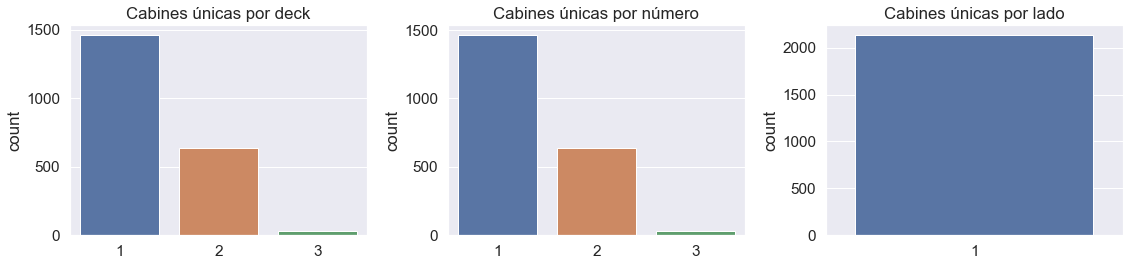

In [528]:
# Grupos por Cabine(gpdc: Grupo por deck, gpnc: Grupo por número da cabine, gpld: Grupo por lado da cabine)
gpdc=datafaltantes[datafaltantes['Tamanho_Grupo']>1].groupby(['Grupo','Deck_Cabine'])['Deck_Cabine'].size().unstack().fillna(0)
gpnc=datafaltantes[datafaltantes['Tamanho_Grupo']>1].groupby(['Grupo','Numero_Cabine'])['Numero_Cabine'].size().unstack().fillna(0)
gpld=datafaltantes[datafaltantes['Tamanho_Grupo']>1].groupby(['Grupo','Lado_Cabine'])['Lado_Cabine'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((gpdc>0).sum(axis=1))
plt.title('Cabines únicas por deck')

plt.subplot(1,3,2)
sns.countplot((gpnc>0).sum(axis=1))
plt.title('Cabines únicas por número')

plt.subplot(1,3,3)
sns.countplot((gpld>0).sum(axis=1))
plt.title('Cabines únicas por lado')
fig.tight_layout()

A relação entre grupos e deck e grupos e número do deck existe uma boa correlação. Agora, na relação entre cabine e lado temos uma correlaçã perfeita, ou seja, pessoas ques estão no mesmo lado da cabine são do mesmo grupo.

In [529]:
#ldcb: Lado_Cabine
ldcb_antes=datafaltantes['Lado_Cabine'].isna().sum()


gpld_index=datafaltantes[datafaltantes['Lado_Cabine'].isna()][(datafaltantes[datafaltantes['Lado_Cabine'].isna()]['Grupo']).isin(gpld.index)].index


datafaltantes.loc[gpld_index,'Lado_Cabine']=datafaltantes.iloc[gpld_index,:]['Grupo'].map(lambda x: gpld.idxmax(axis=1)[x])


print('Lado da cabine faltante antes:',ldcb_antes)
print('Lado da cabine faltante depois:',datafaltantes['Lado_Cabine'].isna().sum())

Lado da cabine faltante antes: 299
Lado da cabine faltante depois: 162


In [530]:
# Sobrenome por lado da cabine(sbld)
sbld=datafaltantes[datafaltantes['Tamanho_Grupo']>1].groupby(['Sobrenome','Lado_Cabine'])['Lado_Cabine'].size().unstack().fillna(0)

# Razão entre sobrenomes e lado da cabine
sbld['Razao_Sobrenome_Lado']=sbld['S']/(sbld['P']+sbld['S'])



Text(0.5, 1.0, 'Razão entre o lado da cabine por sobrenome')

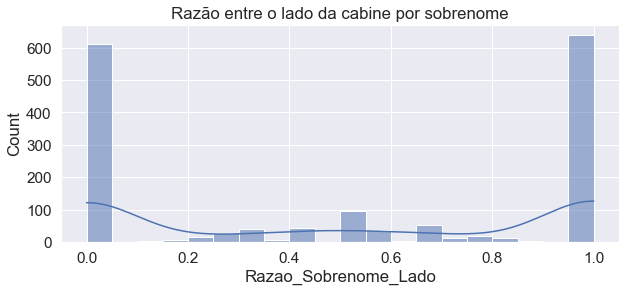

In [531]:
plt.figure(figsize=(10,4))
sns.histplot(sbld['Razao_Sobrenome_Lado'], kde=True, binwidth=0.05)
plt.title('Razão entre o lado da cabine por sobrenome')

Este Histograma me mostra que a grande maioria das famílias estão no mesmo lado da cabine, seja só do lado P(representado pelo 0), ou só do lado S(representado pelo 1).


In [532]:
ldcb_antes=datafaltantes['Lado_Cabine'].isna().sum()

sbld_index=datafaltantes[datafaltantes['Lado_Cabine'].isna()][(datafaltantes[datafaltantes['Lado_Cabine'].isna()]['Sobrenome']).isin(sbld.index)].index


datafaltantes.loc[sbld_index,'Lado_Cabine']=datafaltantes.iloc[sbld_index,:]['Sobrenome'].map(lambda x: sbld.idxmax(axis=1)[x])


datafaltantes.drop('Sobrenome', axis=1, inplace=True)

print('Lado da cabine faltante antes:',ldcb_antes)
print('Lado da cabine faltante depois:',datafaltantes['Lado_Cabine'].isna().sum())

Lado da cabine faltante antes: 162
Lado da cabine faltante depois: 66


Agora iremos substituir os 66 restantes por um outlier, pois não será possível decidir claramente a qual lado cada um pertencerá. 

In [533]:
ldcb_antes=datafaltantes['Lado_Cabine'].isna().sum()


datafaltantes.loc[datafaltantes['Lado_Cabine'].isna(),'Lado_Cabine']='Z'

print('Lado da cabine faltante antes:',ldcb_antes)
print('Lado da cabine faltante depois:',datafaltantes['Lado_Cabine'].isna().sum())

Lado da cabine faltante antes: 66
Lado da cabine faltante depois: 0


In [534]:
deck_antes=datafaltantes['Deck_Cabine'].isna().sum()


gpdc_index=datafaltantes[datafaltantes['Deck_Cabine'].isna()][(datafaltantes[datafaltantes['Deck_Cabine'].isna()]['Grupo']).isin(gpdc.index)].index


datafaltantes.loc[gpdc_index,'Deck_Cabine']=datafaltantes.iloc[gpdc_index,:]['Grupo'].map(lambda x: gpdc.idxmax(axis=1)[x])


print('Deck faltantes antes:',deck_antes)
print('Deck faltantes depois:',datafaltantes['Deck_Cabine'].isna().sum())

Deck faltantes antes: 299
Deck faltantes depois: 162


In [535]:
datafaltantes.groupby(['HomePlanet','Destination','Deck_Cabine'])['Deck_Cabine'].size().unstack().fillna(0)

Deck_Cabine                   A      B      C      D      E       F       G  \
HomePlanet Destination                                                        
Earth      55 Cancri e      0.0    0.0    0.0    0.0   67.0   379.0   541.0   
           PSO J318.5-22    0.0    0.0    0.0    0.0   43.0   329.0   696.0   
           TRAPPIST-1e      0.0    0.0    0.0    0.0  491.0  1788.0  2584.0   
Europa     55 Cancri e    163.0  518.0  472.0  105.0   69.0     0.0     0.0   
           PSO J318.5-22    2.0    5.0   21.0    0.0    0.0     0.0     0.0   
           TRAPPIST-1e    196.0  638.0  629.0  204.0  135.0     0.0     0.0   
Mars       55 Cancri e      0.0    0.0    0.0   72.0   31.0   196.0     0.0   
           PSO J318.5-22    0.0    0.0    0.0   17.0   16.0    35.0     0.0   
           TRAPPIST-1e      0.0    0.0    0.0  332.0  482.0  1541.0     0.0   

Deck_Cabine                 T  
HomePlanet Destination         
Earth      55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    0.0  
Europa     55 Cancri e    2.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    9.0  
Mars       55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    0.0

Irei preencher os dados faltantes do Deck com a moda para cada Deck.

In [536]:
deck_antes=datafaltantes['Deck_Cabine'].isna().sum()

# Fill missing values using the mode
na_rows_CD=datafaltantes.loc[datafaltantes['Deck_Cabine'].isna(),'Deck_Cabine'].index
datafaltantes.loc[datafaltantes['Deck_Cabine'].isna(),'Deck_Cabine']=datafaltantes.groupby(['HomePlanet','Destination'])['Deck_Cabine'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

print('Deck faltantes antes:',deck_antes)
print('Deck faltantes depois:',datafaltantes['Deck_Cabine'].isna().sum())

Deck faltantes antes: 162
Deck faltantes depois: 0


Text(0.5, 1.0, 'Número da Cabine vs Grupo')

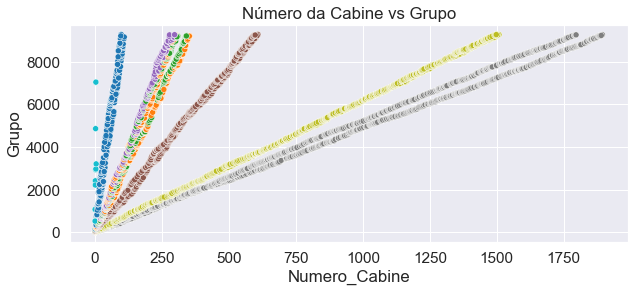

In [537]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=datafaltantes['Numero_Cabine'], y=datafaltantes['Grupo'], c=LabelEncoder().fit_transform(datafaltantes.loc[~datafaltantes['Numero_Cabine'].isna(),'Deck_Cabine']), cmap='tab10')
plt.title('Número da Cabine vs Grupo')

Podemos perceber um padrão linear entre o número da cabine e o grupo de cada passageiro, então irei usar uma regressão linear para preencher estes dados.

In [538]:
numero_cabine_antes=datafaltantes['Numero_Cabine'].isna().sum()


for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    
    X_nc=datafaltantes.loc[~(datafaltantes['Numero_Cabine'].isna()) & (datafaltantes['Deck_Cabine']==deck),'Grupo']
    y_nc=datafaltantes.loc[~(datafaltantes['Numero_Cabine'].isna()) & (datafaltantes['Deck_Cabine']==deck),'Numero_Cabine']
    X_test_nc=datafaltantes.loc[(datafaltantes['Numero_Cabine'].isna()) & (datafaltantes['Deck_Cabine']==deck),'Grupo']

    
    modelo_nc=LinearRegression()
    modelo_nc.fit(X_nc.values.reshape(-1, 1), y_nc)
    preds_nc=modelo_nc.predict(X_test_nc.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    datafaltantes.loc[(datafaltantes['Numero_Cabine'].isna()) & (datafaltantes['Deck_Cabine']==deck),'Numero_Cabine']=preds_nc.astype(int)


print('Número Cabine faltante antes:',numero_cabine_antes)
print('Número Cabine faltante depois:',datafaltantes['Numero_Cabine'].isna().sum())

Número Cabine faltante antes: 299
Número Cabine faltante depois: 0


Para CryoSleep, se um passageiro gastou algo ele não está em CryoSleep. É claro que, não podemos afirmar com certeza que se o passageiro não gastou ele está em CryoSleep, mas vamos considerar isto válido sem muitos problemas.


In [539]:
datafaltantes.groupby(['Gastos_Binario','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
Gastos_Binario,,
0,7339.0,0.0
1,740.0,4581.0


In [540]:
csl_antes=datafaltantes['CryoSleep'].isna().sum()

na_rows_csl=datafaltantes.loc[datafaltantes['CryoSleep'].isna(),'CryoSleep'].index
datafaltantes.loc[datafaltantes['CryoSleep'].isna(),'CryoSleep']=datafaltantes.groupby(['Gastos_Binario'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_csl]

# Print number of missing values left
print('Dados faltantes de CryoSleep antes:',csl_antes)
print('Dados faltantes de CryoSleep antes:',datafaltantes['CryoSleep'].isna().sum())

Dados faltantes de CryoSleep antes: 310
Dados faltantes de CryoSleep antes: 0


Se um passageiro estava em CryoSleep ele não gastou nada durante a viagem. Aqui estamos considerando que um passageiro passa a viagem inteira em CryoSleep.

In [541]:
gastos_antes=datafaltantes[gastos_feats].isna().sum().sum()


for col in gastos_feats:
    datafaltantes.loc[(datafaltantes[col].isna()) & (datafaltantes['CryoSleep']==True), col]=0


print('Dados faltantes de Gastos antes:',gastos_antes)
print('Dados faltantes de Gastos depois:',datafaltantes[gastos_feats].isna().sum().sum())

Dados faltantes de Gastos antes: 1410
Dados faltantes de Gastos depois: 866


Neste caso iremos preencher o restante dos dados com a média dos gastos por Grupo de idade. Isto pode gerar alguns problemas, mas considerando o número de Features não será tão relevante.

In [542]:
gastos_antes=datafaltantes[gastos_feats].isna().sum().sum()


for col in gastos_feats:
    na_rows=datafaltantes.loc[datafaltantes[col].isna(),col].index
    datafaltantes.loc[datafaltantes[col].isna(),col]=datafaltantes.groupby(['Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
print('Dados faltantes de Gastos antes:',gastos_antes)
print('Dados faltantes de Gastos depois:',datafaltantes[gastos_feats].isna().sum().sum())

Dados faltantes de Gastos antes: 866
Dados faltantes de Gastos depois: 0


In [543]:
datafaltantes.isna().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                296
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Age_group            0
Gastos_Totais        0
Gastos_Binario       0
Grupo                0
Tamanho_Grupo        0
Deck_Cabine          0
Numero_Cabine        0
Lado_Cabine          0
Regiao_cabine_1      0
Regiao_cabine_2      0
Regiao_cabine_3      0
Regiao_cabine_4      0
Regiao_cabine_5      0
Regiao_cabine_6      0
Regiao_cabine_7      0
Tamanho_Familia      0
dtype: int64

Agora temos dados faltantes apenas na Feature Vip e como dito anteriormente esta não será utilizada.

# Preparação para os modelos

Separando o datasetfalatntes em treino e teste novamente.


In [544]:
dataset_s_target=datafaltantes[datafaltantes['PassengerId'].isin(dataset['PassengerId'].values)].copy()
datatest=datafaltantes[datafaltantes['PassengerId'].isin(datatest['PassengerId'].values)].copy()

In [545]:
datatest.shape[0]

4277

Retirando as colunas que não vamos utilizar.

In [546]:
dataset_s_target.columns


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Gastos_Totais', 'Gastos_Binario', 'Grupo',
       'Tamanho_Grupo', 'Deck_Cabine', 'Numero_Cabine', 'Lado_Cabine',
       'Regiao_cabine_1', 'Regiao_cabine_2', 'Regiao_cabine_3',
       'Regiao_cabine_4', 'Regiao_cabine_5', 'Regiao_cabine_6',
       'Regiao_cabine_7', 'Tamanho_Familia'],
      dtype='object')

In [547]:
dataset_s_target.drop(['PassengerId', 'Grupo', 'VIP', 'Numero_Cabine'], axis=1, inplace=True)
datatest_modelo = datatest.drop(['PassengerId', 'Grupo', 'VIP', 'Numero_Cabine'], axis=1)

Agora, vamos identificar as variáveis numéricas e categoricas e transformar as categoricas.

In [548]:
colunas_numericas = [cname for cname in dataset_s_target.columns if dataset_s_target[cname].dtype in ['int64', 'float64']]
colunas_categoricas = [cname for cname in dataset_s_target.columns if dataset_s_target[cname].dtype == "object"]


scalando_numericos = Pipeline(steps=[('scaler', StandardScaler())])


transformando_categoricos = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])


ct = ColumnTransformer(
    transformers=[
        ('num', scalando_numericos, colunas_numericas),
        ('cat', transformando_categoricos, colunas_categoricas)],
        remainder='passthrough')

# Apply preprocessing
dataset_s_target = ct.fit_transform(dataset_s_target)
datatest_modelo = ct.transform(datatest_modelo)

# Print new shape
print('Dimensões dados de treino:', dataset_s_target.shape)


Dimensões dados de treino: (8693, 36)


Separando dados de treino em treino e validação.

In [549]:
y=dataset['Transported'].copy().astype(int)

In [550]:
Xtr, Xval, ytr, yval = train_test_split(dataset_s_target,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [551]:
arveres_poderosas = XGBClassifier(learning_rate=0.08, 
                                 n_estimators=800,
                                 max_depth=3,
                                 min_child_weight=1,
                                 subsample=0.8,
                                 colsample_bynode=0.8,
                                 random_state=0,
                                 #gpu_id='0',
                                 #tree_method='gpu_hist',
                                 #num_parallel_tree=3,
                                 booster="gbtree",
                                 objective='reg:squarederror'
                                 )
arveres_poderosas.fit(Xtr, ytr)

p = arveres_poderosas.predict(Xval)

acuracia = accuracy_score(yval, p) * 100
acuracia

79.98849913743531

In [552]:
    modelo = CatBoostClassifier(learning_rate=0.15, 
                                max_depth=4, 
                                n_estimators=100)
    
    modelo.fit(Xtr, ytr)
  
    p = modelo.predict(Xval)
    
    acuracia = accuracy_score(yval, p) * 100
    print("A acurácia foi %.2f%%" % acuracia)
    
    

0:	learn: 0.6296296	total: 3.7ms	remaining: 366ms
1:	learn: 0.5972993	total: 6.84ms	remaining: 335ms
2:	learn: 0.5672960	total: 9.53ms	remaining: 308ms
3:	learn: 0.5441373	total: 12.4ms	remaining: 298ms
4:	learn: 0.5282306	total: 16.4ms	remaining: 312ms
5:	learn: 0.5094353	total: 21.1ms	remaining: 331ms
6:	learn: 0.4952992	total: 24.2ms	remaining: 321ms
7:	learn: 0.4831447	total: 27.2ms	remaining: 312ms
8:	learn: 0.4744489	total: 30.8ms	remaining: 312ms
9:	learn: 0.4667504	total: 34ms	remaining: 306ms
10:	learn: 0.4610506	total: 36.8ms	remaining: 297ms
11:	learn: 0.4566228	total: 39.6ms	remaining: 290ms
12:	learn: 0.4516703	total: 42.3ms	remaining: 283ms
13:	learn: 0.4468581	total: 45.8ms	remaining: 281ms
14:	learn: 0.4419278	total: 49.2ms	remaining: 279ms
15:	learn: 0.4389962	total: 52.2ms	remaining: 274ms
16:	learn: 0.4366739	total: 55.1ms	remaining: 269ms
17:	learn: 0.4342570	total: 58.2ms	remaining: 265ms
18:	learn: 0.4318793	total: 61.4ms	remaining: 262ms
19:	learn: 0.4297693	tota

Usaremos o CatBoost como modelo.

Retreinando com todo os dados e enviando para o Kaggle.

In [553]:
modelo.fit(dataset_s_target, y)

0:	learn: 0.6315654	total: 3.71ms	remaining: 367ms
1:	learn: 0.5900182	total: 7.32ms	remaining: 359ms
2:	learn: 0.5619662	total: 10.3ms	remaining: 332ms
3:	learn: 0.5412340	total: 13ms	remaining: 312ms
4:	learn: 0.5254284	total: 16.1ms	remaining: 307ms
5:	learn: 0.5085365	total: 19.5ms	remaining: 305ms
6:	learn: 0.4975613	total: 22.7ms	remaining: 301ms
7:	learn: 0.4855072	total: 25.8ms	remaining: 296ms
8:	learn: 0.4760887	total: 28.7ms	remaining: 290ms
9:	learn: 0.4696434	total: 32.1ms	remaining: 289ms
10:	learn: 0.4615102	total: 35.7ms	remaining: 289ms
11:	learn: 0.4572239	total: 39.4ms	remaining: 289ms
12:	learn: 0.4533738	total: 42.6ms	remaining: 285ms
13:	learn: 0.4485849	total: 45.9ms	remaining: 282ms
14:	learn: 0.4450475	total: 50.2ms	remaining: 284ms
15:	learn: 0.4424004	total: 53.6ms	remaining: 281ms
16:	learn: 0.4398458	total: 56.5ms	remaining: 276ms
17:	learn: 0.4373106	total: 59.4ms	remaining: 271ms
18:	learn: 0.4343093	total: 62.2ms	remaining: 265ms
19:	learn: 0.4318339	tot

In [554]:
predicoes = modelo.predict(datatest_modelo)

In [555]:
envio = pd.Series(predicoes, index=datatest['PassengerId'], name='Transported')

In [556]:
true_false = {1: True, 0: False}

In [557]:
envio = envio.map(true_false)

Meu score final no Kaggle foi de 0.80780